# Simple Pandemic Simulation
### by Stan Mohler, Jr.
October 2020

I'm not an epidemiologist, just a software engineer.  

Inspired by [this page](https://forum.bayesia.us/t/p8hymxb/webinar-series-reasoning-under-uncertainty-part-3-epidemic-modeling-with-temporal-bayesian-networks), I created a simple simulation of a COVID-19-like pandemic in the US.  I wanted to see whether masks and social distancing would save lives, or just delay the inevitable.  

My simulation follows these simple rules:

- There are 330 million people.  
- Initially, one person is infected.  The rest are susceptible.  
- There is NO vaccine ever.  The only strategy is whether to slow the spread.  
- The simulation advances one day at a time. 
- An infected person is infectious, and remains that way for 14 days.
- While infected, each infected person infects some number of susceptible people.  (The "effective reproduction number.")
- After 14 days, 99% of infected people transition to recovered (and immune).  
- But 1% transition to being dead.  

Here's a diagram:

![Simulation transition diagram](SIDR.PNG)

When a pandemic starts, the initial reproduction number (called R0) tells how many people each infected person infects.  Early on, COVID-19's R0 was estimated to be about 2.5.  (Since then, it's been [revised upward](https://www.forbes.com/sites/tarahaelle/2020/04/07/the-covid19-coronavirus-disease-may-be-twice-as-contagious-as-we-thought/#7665486729a6), but I'll just assume 2.5.  It's just a simulation!)  

Over time, the actual "effective" reproduction number, called Rt, deviates from R0 and [varies over time](https://rt.live), generally downward.  Masks and social distancing reduce Rt.  Growing "herd immunity" does too.  When Rt is less than 1.0, the viral spread is diminshing.    

So I created two scenarios:

| Scenario | R0 value | Description |
| :---     | :---     | :---        |
| 1        | 1.25     | "Slow the spread" |
| 2        | 2.5      | "Live normally, rush to herd immunity" |

Here are the remaining rules: 

- Assume Scenario 1 or 2.  
- As the number of susceptible people shrinks, the effective reproduction number (Rt) shrinks in proportion.  (For example, if an infected person encounters half as many susceptable people, then the disease spreads half as fast.)  
- Rt controls how many people transition from susceptible to infected each day.  Since an infected persion infects their Rt-many people over the course of 14 days, then each infected person infects Rt/14 people per day.  

Like I said, this is a simple simulation.  But it's just complex enough to encompass essential epidemiological dynamics.  

### So...

- **Which scenario above do you think will leave the most people dead in the end: Scenario 1 or 2?**

- **Is it beneficial to slow the spread?**

- **Or does it just delay the inevitable, leaving just as many people dead?**

**Let's find out.**

First, import our Python software libraries.  

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

Next, define our constants.  

In [2]:
NUM_DAYS_SIMULATED                 = 1000
NUM_DAYS_INFECTIOUS                = 14
DEATH_RATE                         = 0.01
TOTAL_POPULATION                   = 330e6
INITIAL_NUM_INFECTIONS             = 1

LOW_INITIAL_REPRODUCTION_NUMBER    = 1.25    # R0, the initial no. of people each contagious person infects
HIGH_INITIAL_REPRODUCTION_NUMBER   = 2.5     # R0 for less social distancing
MAX_DAYS_SOCIAL_DISTANCING         = 9999

Initialize some empty arrays to store the results.  

In [3]:
num_susceptible_arry_arry = []
num_infected_arry_arry    = []
num_immune_arry_arry      = []
num_dead_arry_arry        = []

herd_immunity_day = []
total_dead        = []

Loop over the two scenarios.  For each, loop over all the days of the scenario.  

In [6]:
# LOOP OVER TWO SCENARIOS
for s in range(2):

    infection_dissipating = False
    infection_gone = False

    # set R0 for the current scenario
    initial_reproduction_number = LOW_INITIAL_REPRODUCTION_NUMBER
    if s == 1:
        initial_reproduction_number = HIGH_INITIAL_REPRODUCTION_NUMBER

    print(f'\n\nSCENARIO {s+1} OF 2: Initial reproduction no. = {initial_reproduction_number}')

    # set initial values of the 4 quantities to compute and plot
    num_susceptible = TOTAL_POPULATION - INITIAL_NUM_INFECTIONS
    num_infected    = INITIAL_NUM_INFECTIONS
    num_immune      = 0
    num_dead        = 0

    # initialize arrays to store the time history of the quantities for one scenario
    num_susceptible_arry     = [ num_susceptible ]
    num_infected_arry        = [ num_infected ]
    num_immune_arry          = [ num_immune ]
    num_dead_arry            = [ num_dead ]
    num_infected_today_arry  = [ num_infected ]
    num_recovered_today_arry = [ 0 ]

    # LOOP OVER THE DAYS BEING SIMULATED

    t_10_deaths = None

    for t in range(NUM_DAYS_SIMULATED):

        # when certain things happen, print a message
        if num_infections == 0 and not infection_gone:
            infection_gone = True
            
            if initial_reproduction_number < HIGH_INITIAL_REPRODUCTION_NUMBER:
                initial_reproduction_number = HIGH_INITIAL_REPRODUCTION_NUMBER 
                herd_immunity_day.append(t)
                total_dead.append(num_dead)
                percent_immune = 100 * num_immune / (TOTAL_POPULATION - num_dead)
                print(f'Day {t+1:4}: INFECTION GONE.  {num_dead:.0f} dead.  {percent_immune:.0f}% immune.  ENDING SOCIAL DISTANCING.')

            else:
                herd_immunity_day.append(t)
                total_dead.append(num_dead)
                percent_immune = 100 * num_immune / (TOTAL_POPULATION - num_dead)
                print(f'Day {t+1:4}: INFECTION GONE.  {num_dead:.0f} dead.  {percent_immune:.0f}% immune.')

        # after a long time, both scenarios go to the high reproduction number
        if t >= MAX_DAYS_SOCIAL_DISTANCING and initial_reproduction_number < HIGH_INITIAL_REPRODUCTION_NUMBER:
            print(f'Day {t+1:4}: HIT LIMIT ON DAYS TO SOCIAL DISTANCE.')
            initial_reproduction_number = HIGH_INITIAL_REPRODUCTION_NUMBER
        
        # sick people infect others in proportion to how many are susceptible
        effective_reproduction_number = initial_reproduction_number * num_susceptible / num_susceptible_arry[0]

        # check whether virus is dissipating
        if not infection_dissipating and effective_reproduction_number < 1.0:
            infection_dissipating = True
            percent_immune = 100 * num_immune / (TOTAL_POPULATION - num_dead)
            print(f'Day {t+1:4}: VIRUS IS DISSIPATING: Reproduction number < 1.  {percent_immune:.0f}% immune.')

        # each sick person infects their "victims" over several days
        num_infected_today = num_infected * effective_reproduction_number / NUM_DAYS_INFECTIOUS

        # set default values, which might change farther below
        num_recovered_today     = 0.0
        num_deaths_today        = 0.0
        num_lost_immunity_today = 0.0
        
        if t >= NUM_DAYS_INFECTIOUS:
            # then some infectious people lose their infectiousness today.  
            # How many?  The no. who became infectious NUM_DAYS_INFECTIOUS days ago.  
            num_losing_infectiousness = num_infected_today_arry[ t - NUM_DAYS_INFECTIOUS ]
            num_recovered_today = (1.0 - DEATH_RATE) * num_losing_infectiousness  # most people recover
            num_deaths_today = DEATH_RATE * num_losing_infectiousness             # but some die

        # UPDATE THE 4 QUANTITIES WE WILL PLOT
        num_susceptible = num_susceptible - num_infected_today
        num_infected    = num_infected + num_infected_today - num_recovered_today - num_deaths_today
        num_immune      = num_immune + num_recovered_today
        num_dead        = num_dead + num_deaths_today

        # enable infection to disappear
        if num_infected < 1.0:
            num_infected = 0

        # append the quantities updated above into the time histories
        num_susceptible_arry.append( num_susceptible )        
        num_infected_today_arry.append( num_infected_today )
        num_recovered_today_arry.append( num_recovered_today )
        num_infected_arry.append( num_infected )
        num_immune_arry.append( num_immune )
        num_dead_arry.append( num_dead )

        # PRINT SOME STUFF

        if t == 0 or t == 1 or t > NUM_DAYS_SIMULATED-4:
            print(f'Day {t+1:4}: S={num_susceptible:.2f}  I={num_infected:.2f}  R={num_immune:.2f}  D={num_dead:.2f}')
        
        if t_10_deaths == None and num_dead >= 10:
            t_10_deaths = t

        if t_10_deaths != None and (t - t_10_deaths) == 202:
            # US saw 200,000 deaths 200 days after seeing 10 deaths
            print(f'Day {t+1:4}: 202 days since 10 deaths: US had 200,000 deaths.  Sim has {num_dead:.0f}.')

        # sanity check: total people count should stay constant
        people_count = num_susceptible + num_infected + num_immune + num_dead   # should stay constant
        people_count_error = abs(people_count - TOTAL_POPULATION)
        if people_count_error >= 1:
            print(f'ERROR: People count started at {TOTAL_POPULATION} but is now {people_count}')
            exit()

    # store the latest scenario

    num_susceptible_arry_arry.append(num_susceptible_arry)
    num_infecteds_arry_arry.append(num_infected_arry)
    num_immune_arry_arry.append(num_immune_arry)
    num_dead_arry_arry.append(num_dead_arry)



SCENARIO 1 OF 2: Initial reproduction no. = 1.25
Day    1: S=329999998.91  I=1.09  R=0.00  D=0.00
Day    2: S=329999998.81  I=1.19  R=0.00  D=0.00
Day  364: 202 days since 10 deaths: US had 200,000 deaths.  Sim has 22358.
Day  453: VIRUS IS DISSIPATING: Reproduction number < 1.  14% immune.
Day  935: INFECTION GONE.  1525151 dead.  46% immune.  ENDING SOCIAL DISTANCING.
Day  998: S=177484855.51  I=0.00  R=150989993.05  D=1525151.44
Day  999: S=177484855.51  I=0.00  R=150989993.05  D=1525151.44
Day 1000: S=177484855.51  I=0.00  R=150989993.05  D=1525151.44


SCENARIO 2 OF 2: Initial reproduction no. = 2.5
Day    1: S=329999998.82  I=1.18  R=0.00  D=0.00
Day    2: S=329999998.61  I=1.39  R=0.00  D=0.00
Day  135: VIRUS IS DISSIPATING: Reproduction number < 1.  15% immune.
Day  262: 202 days since 10 deaths: US had 200,000 deaths.  Sim has 3041083.
Day  265: INFECTION GONE.  3041083 dead.  92% immune.
Day  998: S=25891738.66  I=0.00  R=301067178.73  D=3041082.61
Day  999: S=25891738.66  

Finally, plot the results.  

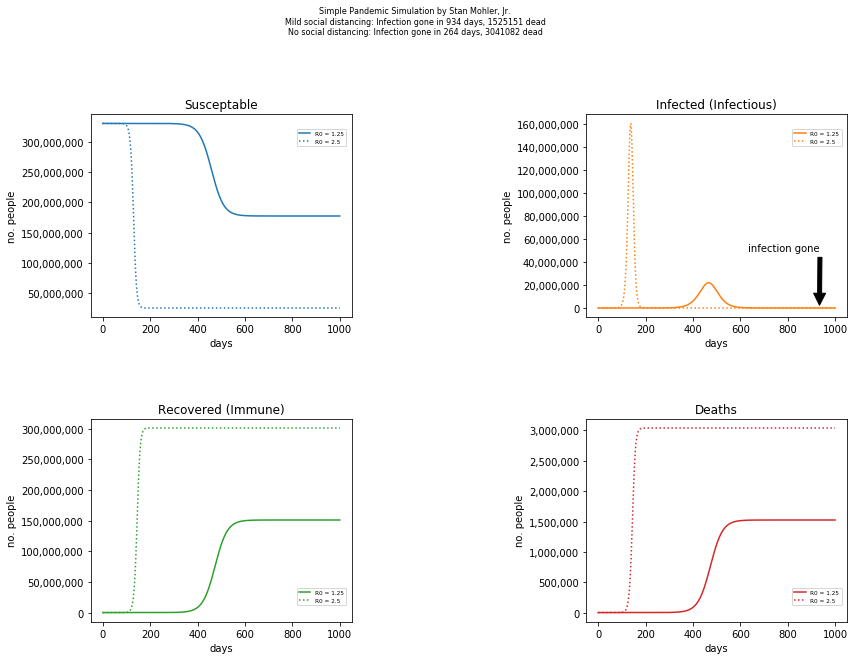

In [7]:
plt.rcParams['figure.figsize'] = 15, 10  # nice big plots
fig, axs = plt.subplots(2, 2)            # 4 plots

# note the day herd immunity was reached & the no. dead
hday0 = str(herd_immunity_day[0])
nd0 = str(int(total_dead[0]))
hday1 = str(herd_immunity_day[1])
nd1 = str(int(total_dead[1]))

fig.suptitle('Simple Pandemic Simulation by Stan Mohler, Jr.\nMild social distancing: Infection gone in '
              + hday0 + ' days, ' + nd0 + ' dead\nNo social distancing: Infection gone in '
              + hday1 + ' days, ' + nd1 + ' dead', fontsize=8)

axs[0, 0].set_title('Susceptable')
axs[0, 1].set_title('Infected (Infectious)')
axs[1, 0].set_title('Recovered (Immune)')
axs[1, 1].set_title('Deaths')

x = range(NUM_DAYS_SIMULATED + 1)

for s in range(2):

    linestyle = '-'
    label = 'R0 = ' + str(LOW_INITIAL_REPRODUCTION_NUMBER)

    if s==1:
        linestyle = ':'
        label = 'R0 = ' + str(HIGH_INITIAL_REPRODUCTION_NUMBER)

    axs[0,0].plot(x, num_susceptible_arry_arry[s], 'tab:blue', linestyle=linestyle, label=label)
    axs[0,1].plot(x, num_infected_arry_arry[s], 'tab:orange', linestyle=linestyle, label=label)
    axs[1,0].plot(x, num_immune_arry_arry[s], 'tab:green', linestyle=linestyle, label=label)
    axs[1,1].plot(x, num_dead_arry_arry[s], 'tab:red', linestyle=linestyle, label=label)

    axs[0,0].legend(bbox_to_anchor=(0.98, 0.93), loc='upper right', borderaxespad=0.02, fontsize='xx-small')
    axs[0,1].legend(bbox_to_anchor=(0.98, 0.93), loc='upper right', borderaxespad=0.02, fontsize='xx-small')
    axs[1,0].legend(bbox_to_anchor=(0.98, 0.08), loc='lower right', borderaxespad=0.02, fontsize='xx-small')
    axs[1,1].legend(bbox_to_anchor=(0.98, 0.08), loc='lower right', borderaxespad=0.02, fontsize='xx-small')

for ax in axs.flat:
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set(xlabel='days', ylabel='no. people')

plt.subplots_adjust(left=0.2, bottom=None, right=None, top=0.83, wspace=0.9, hspace=0.5)

axs[0,1].annotate('infection gone', xy=(herd_immunity_day[0], 0), xytext=(herd_immunity_day[0]-300, 50e6),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

plt.show()

## Results
In the plots above: 
- Dotted curves are for living as normal, hoping for rapid herd immunity.  
- Solid curves are for slowing the spread.  
- When everything truly levels off, the pandemic is over.  The virus is gone.  

In the upper right figure, notice: 
- **Slowing the spread delays the peak of the infection, widens it, and drastically reduces its height.**  (All very helpful to hospitals).
- Therefore a better simulation would dramatically increase the death rate for that high dotted peak in which **half the country** (!) is infected at the same time.  
- Slowing the spread also can cause the virus **to appear almost non-existent for a long time**, but then **suddenly explode into visibility** (as happens around day 350).  The illusion of "nothing happening" is removed via a log plot, shown below, in which 10 is replaced by 1, 100 is replaced by 2, 1000 is replaced by 3, etc.  As you can see, the virus is actually spreading at a constant exponential rate, getting worse and worse, long before the **surprise "explosion."**  (Maybe that's why CDC director Redfield warned that [fall 2020 could be "the worst"](https://www.npr.org/sections/coronavirus-live-updates/2020/08/13/902388083/cdc-director-warns-this-fall-could-be-the-worst-ever-for-public-health) for public health.)  

![Log of people infected](LogNumPeople.PNG)

In the first four plots up above, the red curves, in the lower right figure, have the key findings:
- Allowing the virus to rapidly spread ends the pandemic much sooner. BUT it ends up killing far more people.  That's because the rate of new infections out-races the growing herd immunity.  Many more people die before a given level of herd immunity can do its job.  
- **Slowing the spread definitely delays herd immunity, by a long time.**  Years, even.  
- **BUT IT DRAMATICALLY REDUCES THE NUMBER OF DEATHS.**  In this case, it cuts deaths in half, saving about 1.5 million lives.  (Even more if you consider that hospitals wouldn't be overwhelmed.)

### Therefore it appears that everyone running around living life as normal would lead to disaster.  It would kill millions of people who are saved by slowing the spread.

Now consider a 3rd strategy:
- Let the virus spread at its natural rate (R0 = 2.5 here) until 100 people are infected.  
- At that point, impose a tight lockdown, possibly just in the vicinity of those 100 people, stopping further infection in its tracks (Rt = 0).  
- Stay locked down until all those 100 people become incapable of spreading the infection - about 14 days.  (In real life, we'd have to test widely, to discover all infections.)  
- Then, let R0 rise back to 2.5, i.e., resume normal life.

What would happen?

It seems obvious: It would end the pandemic in a matter of days, with only a few deaths.  

Is such a strategy realistic?  **Yes.**  It was implemented **in real life** by the WHO's GPHIN, which nipped SARS in the bud, **preventing a global pandemic in 2003**.  Dr. Larry Brilliant explains it 16 minutes into [his 2006 TED talk](https://www.youtube.com/watch?v=MNhiHf84P9c).  He also helped eradicate the smallpox virus from the face of the earth in 1980, and possibly polio.  
